<a href="https://colab.research.google.com/github/ShiroTaka7/RealEstateAgent/blob/master/classify_tutorials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**データの分類，モデルの作成と学習と評価（TensorFlow，Keras，TensorFlow データセットのMNIST データセットを使用）**

ニューラルネットワークの作成，学習，データの分類を行う． TensorFlow データセットの MNIST データセットを使用する．

・Keras を用いたニューラルネットワークのモデルの作成
 
・ニューラルネットワークの学習

・ニューラルネットワークによるデータの分類 

説明ページ: https://www.kkaneko.jp/dblab/classify/tutorials.html

関連の用語集: https://www.kkaneko.jp/dblab/man.html

**ニューラルネットワークの作成，MNIST データセットを用いた学習とデータの分類**

１．**パッケージのインポートと TensorFlow のバージョン確認**

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings
tf.enable_v2_behavior()
from tensorflow.keras import backend as K
K.clear_session()

print(tf.__version__)

2.4.1


２．**MNIST データセットのロード**

tensorflow_datasets の loadで，「batch_size = -1」を指定して，一括読み込みを行っている． 

In [ ]:
mnist, mnist_info = tfds.load('mnist', with_info = True, shuffle_files=True, as_supervised=True, batch_size = -1)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


３．**データセットの中の画像を表示**


MatplotLib を用いて，0 番目の画像を表示する 

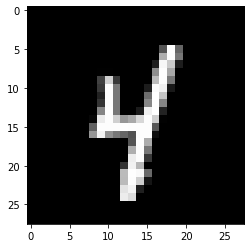

In [ ]:
import matplotlib.pyplot as plt
NUM = 0
# NUM 番目の画像を表示
plt.imshow(mnist['train'][0][NUM].numpy()[:, :, 0], cmap=plt.get_cmap('gray'))

MatplotLib を用いて，複数の画像を並べて表示する． 

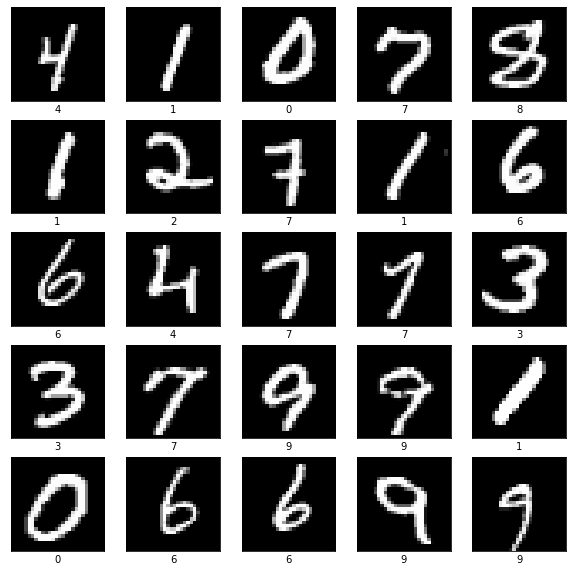

In [ ]:
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  image, label = mnist['train'][0][i], mnist['train'][1][i]
  plt.imshow(image.numpy()[:, :, 0].astype(np.float32), cmap=plt.get_cmap('gray'))
  plt.xlabel(label.numpy())

plt.show()

４．**データセットの情報を表示** 

In [ ]:
print(mnist_info)
print(mnist_info.features["label"].num_classes)
print(mnist_info.features["label"].names)

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)

10
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


５．**mnist['train'] と mnist['test'] の形と次元を確認**

mnist['train']: サイズ **28 × 28** の **60000**枚の濃淡画像，**60000**枚の濃淡画像それぞれのラベル(0 から 9 のどれか)

mnist['test']: サイズ **28 × 28** の**10000**枚の濃淡画像，**10000**枚の濃淡画像それぞれのラベル(0 から 9 のどれか) 

In [ ]:
print(mnist['train'][0].shape)
print(mnist['train'][1].shape)
print(mnist['test'][0].shape)
print(mnist['test'][1].shape)

(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


６．**主成分分析の結果である主成分スコアのプロット**

mnist['train'], mnist['test'] の表示

mnist['train'][0], mnist['test'][0] は主成分分析で２次元にマッピング， mnist['train'][1], mnist['test'][1] は色． 

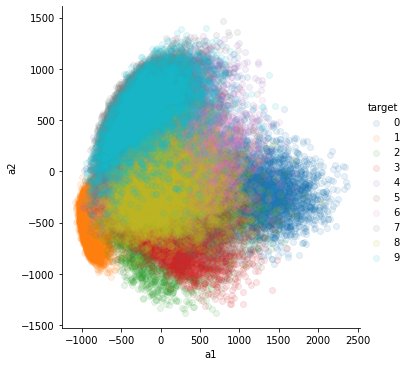

In [ ]:
import pandas as pd
import seaborn 
import sklearn.decomposition
# 主成分分析でプロット
def pcaplot(A, b, alpha):
    pca = sklearn.decomposition.PCA(n_components=2)
    pca.fit(A)
    a12 = pd.DataFrame( pca.fit_transform(A), columns=['a1', 'a2'] )
    a12['target'] = b
    seaborn.lmplot(x='a1', y='a2', data=a12, hue='target', scatter_kws={'alpha': alpha}, fit_reg=False)

pcaplot(np.reshape(mnist['train'][0], (60000, 784)), mnist['train'][1], 0.1)

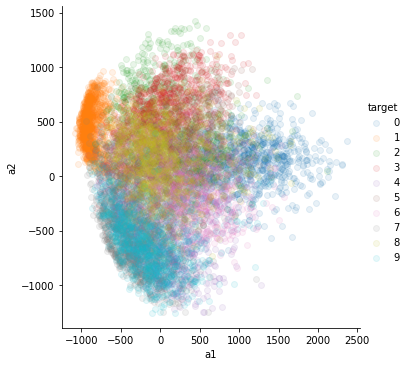

In [ ]:
pcaplot(np.reshape(mnist['test'][0], (10000, 784)), mnist['test'][1], 0.1)

７．**データセットの生成**




In [ ]:
ds_train, ds_test = mnist['train'], mnist['test']

８．**ニューラルネットワークを使うために，データの前処理**

値は，もともと int で 0 から 255 の範囲であるのを， float32 で 0　から 1 の範囲になるように前処理を行う． 

In [ ]:
ds_train = (ds_train[0].numpy().astype("float32") / 255., ds_train[1])
ds_test = (ds_test[0].numpy().astype("float32") / 255., ds_test[1])

９．**モデルの作成と確認とコンパイル**

ニューラルネットワークの種類： 層構造 (Sequential Model)

ニューラルネットワークの構成

・Flatten の層: 画像（**28かける28**）を 1次元の配列に変換する．

・１層目: Dense（全結合），ニューロン（ユニット）の個数: **64**

・２層目: Dense（全結合），ニューロン（ユニット）の個数: **10**

・２層目のニューロン（ユニット）の種類: **softmax**

・１番目のDense の層と２番目のDense の層の間の結合については，ドロップアウトを行う． 

最適化器（オプティマイザ） と損失関数とメトリクスを設定する．

    Keras のオプティマイザのページ: https://keras.io/api/optimizers/
    Keras の損失関数のページ: https://keras.io/api/losses/
    Keras のメトリクスのページ: https://keras.io/api/losses/ 






In [ ]:
NUM_CLASSES = 10

m = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28, 1)),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(0.05),
    tf.keras.layers.Dense(units=NUM_CLASSES, activation='softmax')
])
m.summary()
m.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_crossentropy', 'accuracy']
)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 50,890
Trainable params: 50,890
Non-trainable params: 0
_________________________________________________________________


１０．**モデルのビジュアライズ**


In [ ]:
from tensorflow.keras.utils import plot_model
import pydot
plot_model(m)

NameError: ignored

１１．**学習（訓練）**

学習（訓練）は fit メソッドにより行う． 学習データを投入する． 

In [ ]:
EPOCHS = 20
history = m.fit(ds_train[0], ds_train[1],
                    epochs=EPOCHS,
                    validation_data=(ds_test[0], ds_test[1]), 
                    verbose=1)

１２．**ニューラルネットワークによる分類**

ds_test を分類してみる． 

In [ ]:
print(m.predict(ds_test[0]))

それぞれの数値の中で、一番大きいものはどれか？ 

In [ ]:
m.predict(ds_test[0]).argmax(axis=1)

ds_test 内にある正解のラベル（クラス名）を表示する（上の結果と比べるため） 

In [ ]:
print(ds_test[1])

１３．**学習曲線の確認**

過学習や学習不足について確認． 

In [ ]:
import pandas as pd
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print(hist)

１４．**学習曲線のプロット**

過学習や学習不足について確認．

https://www.tensorflow.org/tutorials/keras/overfit_and_underfit?hl=ja で公開されているプログラムを使用 

In [ ]:
import matplotlib.pyplot as plt
def plot_history(histories, key='binary_crossentropy'):
  plt.figure(figsize=(16,10))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])


plot_history([('history', history)], key='sparse_categorical_crossentropy')

In [ ]:
plot_history([('history', history)], key='accuracy')